## Библиотеки

In [1]:
def plt_null_df(df):

    plt.figure(figsize=(30, 18))

    plt.imshow(df, aspect="auto", interpolation="nearest", cmap="viridis")

    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')

    plt.xlabel("Column Number")
    plt.ylabel("Sample Number")

    plt.show()

In [63]:
# Необходимые библиотеки
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
import warnings
from IPython.display import display, HTML


import os
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
# import optuna
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pandas as pd
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier


import numpy as np
import time
import json

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)

# Отключить все предупреждения временно
import warnings
warnings.filterwarnings("ignore")

## Загрузка и изучение данных

In [3]:
def read_df(path: str) -> pd.DataFrame:
    """
    Функция для чтения DataFrame из Parquet-файла.

    Параметры:
    path (str): Путь к Parquet-файлу.

    Возвращает:
    pd.DataFrame: DataFrame, прочитанный из Parquet-файла.

    """
    if os.path.exists(path):
        df = pd.read_parquet(path)
        print(f'Успешно: Данные {path} загружены')
        return df
    else:
        print(f'Ошибка: {path} не найден')
        return None

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# Путь до файла train_df
path_train_df = "/kaggle/input/alfa-hackaton/train_data.pqt"

# Путь до файла test_df
path_test_df = "/kaggle/input/alfa-hackaton/test_data.pqt"

# # Путь до файла train_df
# path_train_df = "/content/drive/MyDrive/Alfa-hak/train_data.pqt"

# # Путь до файла test_df
# path_test_df = "/content/drive/MyDrive/Alfa-hak/test_data.pqt"


train_df = read_df(path=path_train_df)
test_df = read_df(path=path_test_df)

Успешно: Данные /kaggle/input/alfa-hackaton/train_data.pqt загружены
Успешно: Данные /kaggle/input/alfa-hackaton/test_data.pqt загружены


## Предобработка данных

In [ ]:
df = pd.concat([train_df, test_df], ignore_index=True)
df['date'] = df['date'].replace({'month_4': 'month_1', 'month_5': 'month_2', 'month_6': 'month_3'})


columns_to_drop = [
    
    'index_city_code',
    'max_founderpres',
    'min_founderpres',
    'ogrn_exist_months',
]


df = df.drop(columns=columns_to_drop)


cat_cols = [
          "channel_code", "city", "city_type",
          "okved", "segment", "start_cluster", "ogrn_month", "ogrn_year",
      ]

df[cat_cols] = df[cat_cols].astype("object")

In [22]:
class RestoreCategoricalTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def restore_cal(self, x):
        if x.isna().any() and not x.isna().all():
            return x.fillna(x.dropna().iloc[-1])
        elif x.isna().all():
            return x.fillna('missing')
        return x
    def transform(self, X):
        cat_columns_to_restore = ['channel_code', 'city', 'city_type', 'ogrn_month', 'ogrn_year', 'okved', 'segment']
        for column in cat_columns_to_restore:
            start_time = time.time()
            X[column] = X.groupby('id')[column].apply(self.restore_cal).reset_index()[column]
            end_time = time.time()
            print(f"Колонка - {column} - восстановлена {end_time - start_time}")
        return X

In [68]:
class AddNewFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, df):
        df['avg_a_oper_1m'] = df['sum_a_oper_1m'] / df['cnt_a_oper_1m']
        df['avg_b_oper_1m'] = df['sum_b_oper_1m'] / df['cnt_b_oper_1m']
        df['avg_c_oper_1m'] = df['sum_c_oper_1m'] / df['cnt_c_oper_1m']

        df['avg_deb_d_oper_1m'] = df['sum_deb_d_oper_1m'] / df['cnt_deb_d_oper_1m']
        df['avg_cred_d_oper_1m'] = df['sum_cred_d_oper_1m'] / df['cnt_cred_d_oper_1m']

        df['avg_deb_e_oper_1m'] = df['sum_deb_e_oper_1m'] / df['cnt_deb_e_oper_1m']
        df['avg_cred_e_oper_1m'] = df['sum_cred_e_oper_1m'] / df['cnt_cred_e_oper_1m']


        df['avg_deb_f_oper_1m'] = df['sum_deb_f_oper_1m'] / df['cnt_deb_f_oper_1m']
        df['avg_cred_f_oper_1m'] = df['sum_cred_f_oper_1m'] / df['cnt_cred_f_oper_1m']

        df['avg_deb_g_oper_1m'] = df['sum_deb_g_oper_1m'] / df['cnt_deb_g_oper_1m']
        df['avg_cred_g_oper_1m'] = df['sum_cred_g_oper_1m'] / df['cnt_cred_g_oper_1m']

        df['avg_deb_h_oper_1m'] = df['sum_deb_h_oper_1m'] / df['cnt_deb_h_oper_1m']
        df['avg_cred_h_oper_1m'] = df['sum_cred_h_oper_1m'] / df['cnt_cred_h_oper_1m']


        df['avg_a_oper_3m'] = df['sum_a_oper_3m'] / df['cnt_a_oper_3m']
        df['avg_b_oper_3m'] = df['sum_b_oper_3m'] / df['cnt_b_oper_3m']
        df['avg_c_oper_3m'] = df['sum_c_oper_3m'] / df['cnt_c_oper_3m']

        df['avg_deb_d_oper_3m'] = df['sum_deb_d_oper_3m'] / df['cnt_deb_d_oper_3m']
        df['avg_cred_d_oper_3m'] = df['sum_cred_d_oper_3m'] / df['cnt_cred_d_oper_3m']

        df['avg_deb_e_oper_3m'] = df['sum_deb_e_oper_3m'] / df['cnt_deb_e_oper_3m']
        df['avg_cred_e_oper_3m'] = df['sum_cred_e_oper_3m'] / df['cnt_cred_e_oper_3m']

        df['avg_deb_f_oper_3m'] = df['sum_deb_f_oper_3m'] / df['cnt_deb_f_oper_3m']
        df['avg_cred_f_oper_3m'] = df['sum_cred_f_oper_3m'] / df['cnt_cred_f_oper_3m']

        df['avg_deb_g_oper_3m'] = df['sum_deb_g_oper_3m'] / df['cnt_deb_g_oper_3m']
        df['avg_cred_g_oper_3m'] = df['sum_cred_g_oper_3m'] / df['cnt_cred_g_oper_3m']

        df['avg_deb_h_oper_3m'] = df['sum_deb_h_oper_3m'] / df['cnt_deb_h_oper_3m']
        df['avg_cred_h_oper_3m'] = df['sum_cred_h_oper_3m'] / df['cnt_cred_h_oper_3m']
        return df

In [69]:
categorical_features = ['channel_code', 'city', 'city_type', 'ogrn_month', 'ogrn_year', 'okved', 'segment']

numeric_features = df.drop(columns=['id']).select_dtypes(include=['number']).columns.tolist()


# Pipeline для категориальных данных
cat_pipeline = Pipeline(steps=[
    ('restore_categorical', RestoreCategoricalTransformer())
])

# Pipeline для числовых данных
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

# Объединение преобразованных данных
preprocessing_steps = FeatureUnion(transformer_list=[
#     ('categorical_pipeline', cat_pipeline),
    ('numerical_pipeline', num_pipeline),
    ('add_features', AddNewFeatures())
])

In [25]:
start_time = time.time()
transformed_df = cat_pipeline.transform(df)
end_time = time.time()
print(end_time - start_time)
transformed_df

Колонка - channel_code - восстановлена 61.26072454452515
Колонка - city - восстановлена 65.25699424743652
Колонка - city_type - восстановлена 68.33462262153625
Колонка - ogrn_month - восстановлена 66.28091382980347
Колонка - ogrn_year - восстановлена 69.9211208820343
Колонка - okved - восстановлена 67.92520523071289
Колонка - segment - восстановлена 70.62450385093689
469.6049790382385


,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.7448,0.7055,1.2872,0.7481,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9512,0.5687,0.8976,0.5536,0.7744,0.9365,0.2960,0.9679,"{α, γ}",{other}
1,0,month_2,1.0496,0.8319,2.4586,1.0538,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9488,0.4997,0.7850,0.5519,0.6966,0.9902,0.2989,0.9460,"{α, γ}",{other}
2,0,month_3,0.6927,0.7403,0.4300,0.6957,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9465,0.4422,0.8770,0.5510,0.6632,0.8101,0.2948,0.9570,"{α, γ}",{other}
3,1,month_1,-0.0816,-0.0919,-0.1140,-0.0809,channel_code_2,city_14,city_type_0,None,...,0.9453,0.4078,0.3693,0.5671,0.7855,-0.1840,0.2535,0.4625,{other},{other}
4,1,month_2,-0.0950,-0.1005,-0.1193,-0.0943,channel_code_2,city_14,city_type_0,None,...,0.9461,0.4308,0.0673,0.5599,0.6966,-0.1839,0.2555,0.4954,{other},{other}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890115,299998,month_5,NaN,NaN,NaN,NaN,channel_code_9,city_25,city_type_0,None,...,NaN,NaN,-0.1656,NaN,NaN,-0.2011,NaN,NaN,{},NaN
890116,299998,month_6,-0.1553,-0.2037,-0.1260,-0.1560,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.9445,0.3848,-0.1656,0.5469,0.4077,-0.2011,0.2509,0.3745,None,NaN
890117,299999,month_4,-0.1459,-0.1733,-0.1260,-0.1454,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.9445,0.3848,-0.0976,0.5509,0.5744,-0.1014,0.2527,0.4405,{α},NaN
890118,299999,month_5,-0.1364,-0.1639,-0.1215,-0.1359,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.9445,0.3848,-0.0479,0.5551,0.6966,-0.0349,0.2535,0.4734,{α},NaN


In [74]:
transformed_df = pd.read_parquet("transformed_df.pqt")

In [75]:
transformed_df.head()

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.7448,0.7055,1.2872,0.7481,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9512,0.5687,0.8976,0.5536,0.7744,0.9365,0.2960,0.9679,"{α, γ}",{other}
1,0,month_2,1.0496,0.8319,2.4586,1.0538,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9488,0.4997,0.7850,0.5519,0.6966,0.9902,0.2989,0.9460,"{α, γ}",{other}
2,0,month_3,0.6927,0.7403,0.4300,0.6957,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9465,0.4422,0.8770,0.5510,0.6632,0.8101,0.2948,0.9570,"{α, γ}",{other}
3,1,month_1,-0.0816,-0.0919,-0.1140,-0.0809,channel_code_2,city_14,city_type_0,None,...,0.9453,0.4078,0.3693,0.5671,0.7855,-0.1840,0.2535,0.4625,{other},{other}
4,1,month_2,-0.0950,-0.1005,-0.1193,-0.0943,channel_code_2,city_14,city_type_0,None,...,0.9461,0.4308,0.0673,0.5599,0.6966,-0.1839,0.2555,0.4954,{other},{other}


In [77]:
# Separate numeric and categorical features
numeric_features = df.drop(columns=['id']).select_dtypes(include=['number']).columns.tolist()
categorical_features = ['channel_code', 'city', 'city_type', 'ogrn_month', 'ogrn_year', 'okved', 'segment']

# Pipeline for numerical data
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

# Pipeline for categorical data
cat_pipeline = Pipeline(steps=[
    ('restore_categorical', RestoreCategoricalTransformer())
])

# ColumnTransformer to apply different pipelines to different columns
preprocessing_steps = ColumnTransformer(transformers=[
    ('numeric_pipeline', num_pipeline, numeric_features),
#     ('categorical_pipeline', cat_pipeline, categorical_features)
])

# Full pipeline including feature engineering
full_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_steps),
    ('add_features', AddNewFeatures())
])

transformed_df = full_pipeline.fit_transform(transformed_df)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [78]:
transformed_df

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.7448,0.7055,1.2872,0.7481,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9512,0.5687,0.8976,0.5536,0.7744,0.9365,0.2960,0.9679,"{α, γ}",{other}
1,0,month_2,1.0496,0.8319,2.4586,1.0538,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9488,0.4997,0.7850,0.5519,0.6966,0.9902,0.2989,0.9460,"{α, γ}",{other}
2,0,month_3,0.6927,0.7403,0.4300,0.6957,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.9465,0.4422,0.8770,0.5510,0.6632,0.8101,0.2948,0.9570,"{α, γ}",{other}
3,1,month_1,-0.0816,-0.0919,-0.1140,-0.0809,channel_code_2,city_14,city_type_0,None,...,0.9453,0.4078,0.3693,0.5671,0.7855,-0.1840,0.2535,0.4625,{other},{other}
4,1,month_2,-0.0950,-0.1005,-0.1193,-0.0943,channel_code_2,city_14,city_type_0,None,...,0.9461,0.4308,0.0673,0.5599,0.6966,-0.1839,0.2555,0.4954,{other},{other}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890115,299998,month_5,NaN,NaN,NaN,NaN,channel_code_9,city_25,city_type_0,None,...,NaN,NaN,-0.1656,NaN,NaN,-0.2011,NaN,NaN,{},None
890116,299998,month_6,-0.1553,-0.2037,-0.1260,-0.1560,channel_code_9,city_25,city_type_0,index_city_code_30,...,0.9445,0.3848,-0.1656,0.5469,0.4077,-0.2011,0.2509,0.3745,None,None
890117,299999,month_4,-0.1459,-0.1733,-0.1260,-0.1454,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.9445,0.3848,-0.0976,0.5509,0.5744,-0.1014,0.2527,0.4405,{α},None
890118,299999,month_5,-0.1364,-0.1639,-0.1215,-0.1359,channel_code_9,city_6,city_type_0,index_city_code_34,...,0.9445,0.3848,-0.0479,0.5551,0.6966,-0.0349,0.2535,0.4734,{α},None


In [50]:
plt_null_df(transformed_df.isna())

AttributeError: 'numpy.ndarray' object has no attribute 'isna'

In [29]:
transformed_df.to_parquet("transformed_df.pqt")

## Feature engineering

Тут кратко описание секции

####  Воостановление категориальных данных

In [21]:
df.to_parquet("df_after_cat_restore.pqt")

In [168]:
df = pd.read_parquet("df_after_cat_restore.pqt")

###  AVG

Очень много плохих столбцов sum но  cnt хорошие и можно сгенирировать avg

In [169]:
# mean по датасету
numeric_cols = df.select_dtypes(include=['number']).columns[1:]
for col in numeric_cols:
    mean_val = df[col].mean()
    df[col].fillna(mean_val, inplace=True)

In [150]:
# filled_df = df.copy()
# for column in filled_df.select_dtypes(include=['number']).columns[1:]:  
#     filled_df[column] = filled_df.groupby('okved')[column].transform(lambda x: x.fillna(x.mean()))


In [48]:
# df = filled_df

In [152]:
# # mean по датасету по каждой категории
# numeric_cols = df.select_dtypes(include=['number']).columns[1:]
# for col in numeric_cols:
#     min_val = df[col].mean()
#     df[col].fillna(min_val, inplace=True)

In [171]:
df['avg_a_oper_1m'] = df['sum_a_oper_1m'] / df['cnt_a_oper_1m']
df['avg_b_oper_1m'] = df['sum_b_oper_1m'] / df['cnt_b_oper_1m']
df['avg_c_oper_1m'] = df['sum_c_oper_1m'] / df['cnt_c_oper_1m']

df['avg_deb_d_oper_1m'] = df['sum_deb_d_oper_1m'] / df['cnt_deb_d_oper_1m']
df['avg_cred_d_oper_1m'] = df['sum_cred_d_oper_1m'] / df['cnt_cred_d_oper_1m']

df['avg_deb_e_oper_1m'] = df['sum_deb_e_oper_1m'] / df['cnt_deb_e_oper_1m']
df['avg_cred_e_oper_1m'] = df['sum_cred_e_oper_1m'] / df['cnt_cred_e_oper_1m']


df['avg_deb_f_oper_1m'] = df['sum_deb_f_oper_1m'] / df['cnt_deb_f_oper_1m']
df['avg_cred_f_oper_1m'] = df['sum_cred_f_oper_1m'] / df['cnt_cred_f_oper_1m']

df['avg_deb_g_oper_1m'] = df['sum_deb_g_oper_1m'] / df['cnt_deb_g_oper_1m']
df['avg_cred_g_oper_1m'] = df['sum_cred_g_oper_1m'] / df['cnt_cred_g_oper_1m']

df['avg_deb_h_oper_1m'] = df['sum_deb_h_oper_1m'] / df['cnt_deb_h_oper_1m']
df['avg_cred_h_oper_1m'] = df['sum_cred_h_oper_1m'] / df['cnt_cred_h_oper_1m']


df['avg_a_oper_3m'] = df['sum_a_oper_3m'] / df['cnt_a_oper_3m']
df['avg_b_oper_3m'] = df['sum_b_oper_3m'] / df['cnt_b_oper_3m']
df['avg_c_oper_3m'] = df['sum_c_oper_3m'] / df['cnt_c_oper_3m']

df['avg_deb_d_oper_3m'] = df['sum_deb_d_oper_3m'] / df['cnt_deb_d_oper_3m']
df['avg_cred_d_oper_3m'] = df['sum_cred_d_oper_3m'] / df['cnt_cred_d_oper_3m']

df['avg_deb_e_oper_3m'] = df['sum_deb_e_oper_3m'] / df['cnt_deb_e_oper_3m']
df['avg_cred_e_oper_3m'] = df['sum_cred_e_oper_3m'] / df['cnt_cred_e_oper_3m']

df['avg_deb_f_oper_3m'] = df['sum_deb_f_oper_3m'] / df['cnt_deb_f_oper_3m']
df['avg_cred_f_oper_3m'] = df['sum_cred_f_oper_3m'] / df['cnt_cred_f_oper_3m']

df['avg_deb_g_oper_3m'] = df['sum_deb_g_oper_3m'] / df['cnt_deb_g_oper_3m']
df['avg_cred_g_oper_3m'] = df['sum_cred_g_oper_3m'] / df['cnt_cred_g_oper_3m']

df['avg_deb_h_oper_3m'] = df['sum_deb_h_oper_3m'] / df['cnt_deb_h_oper_3m']
df['avg_cred_h_oper_3m'] = df['sum_cred_h_oper_3m'] / df['cnt_cred_h_oper_3m']

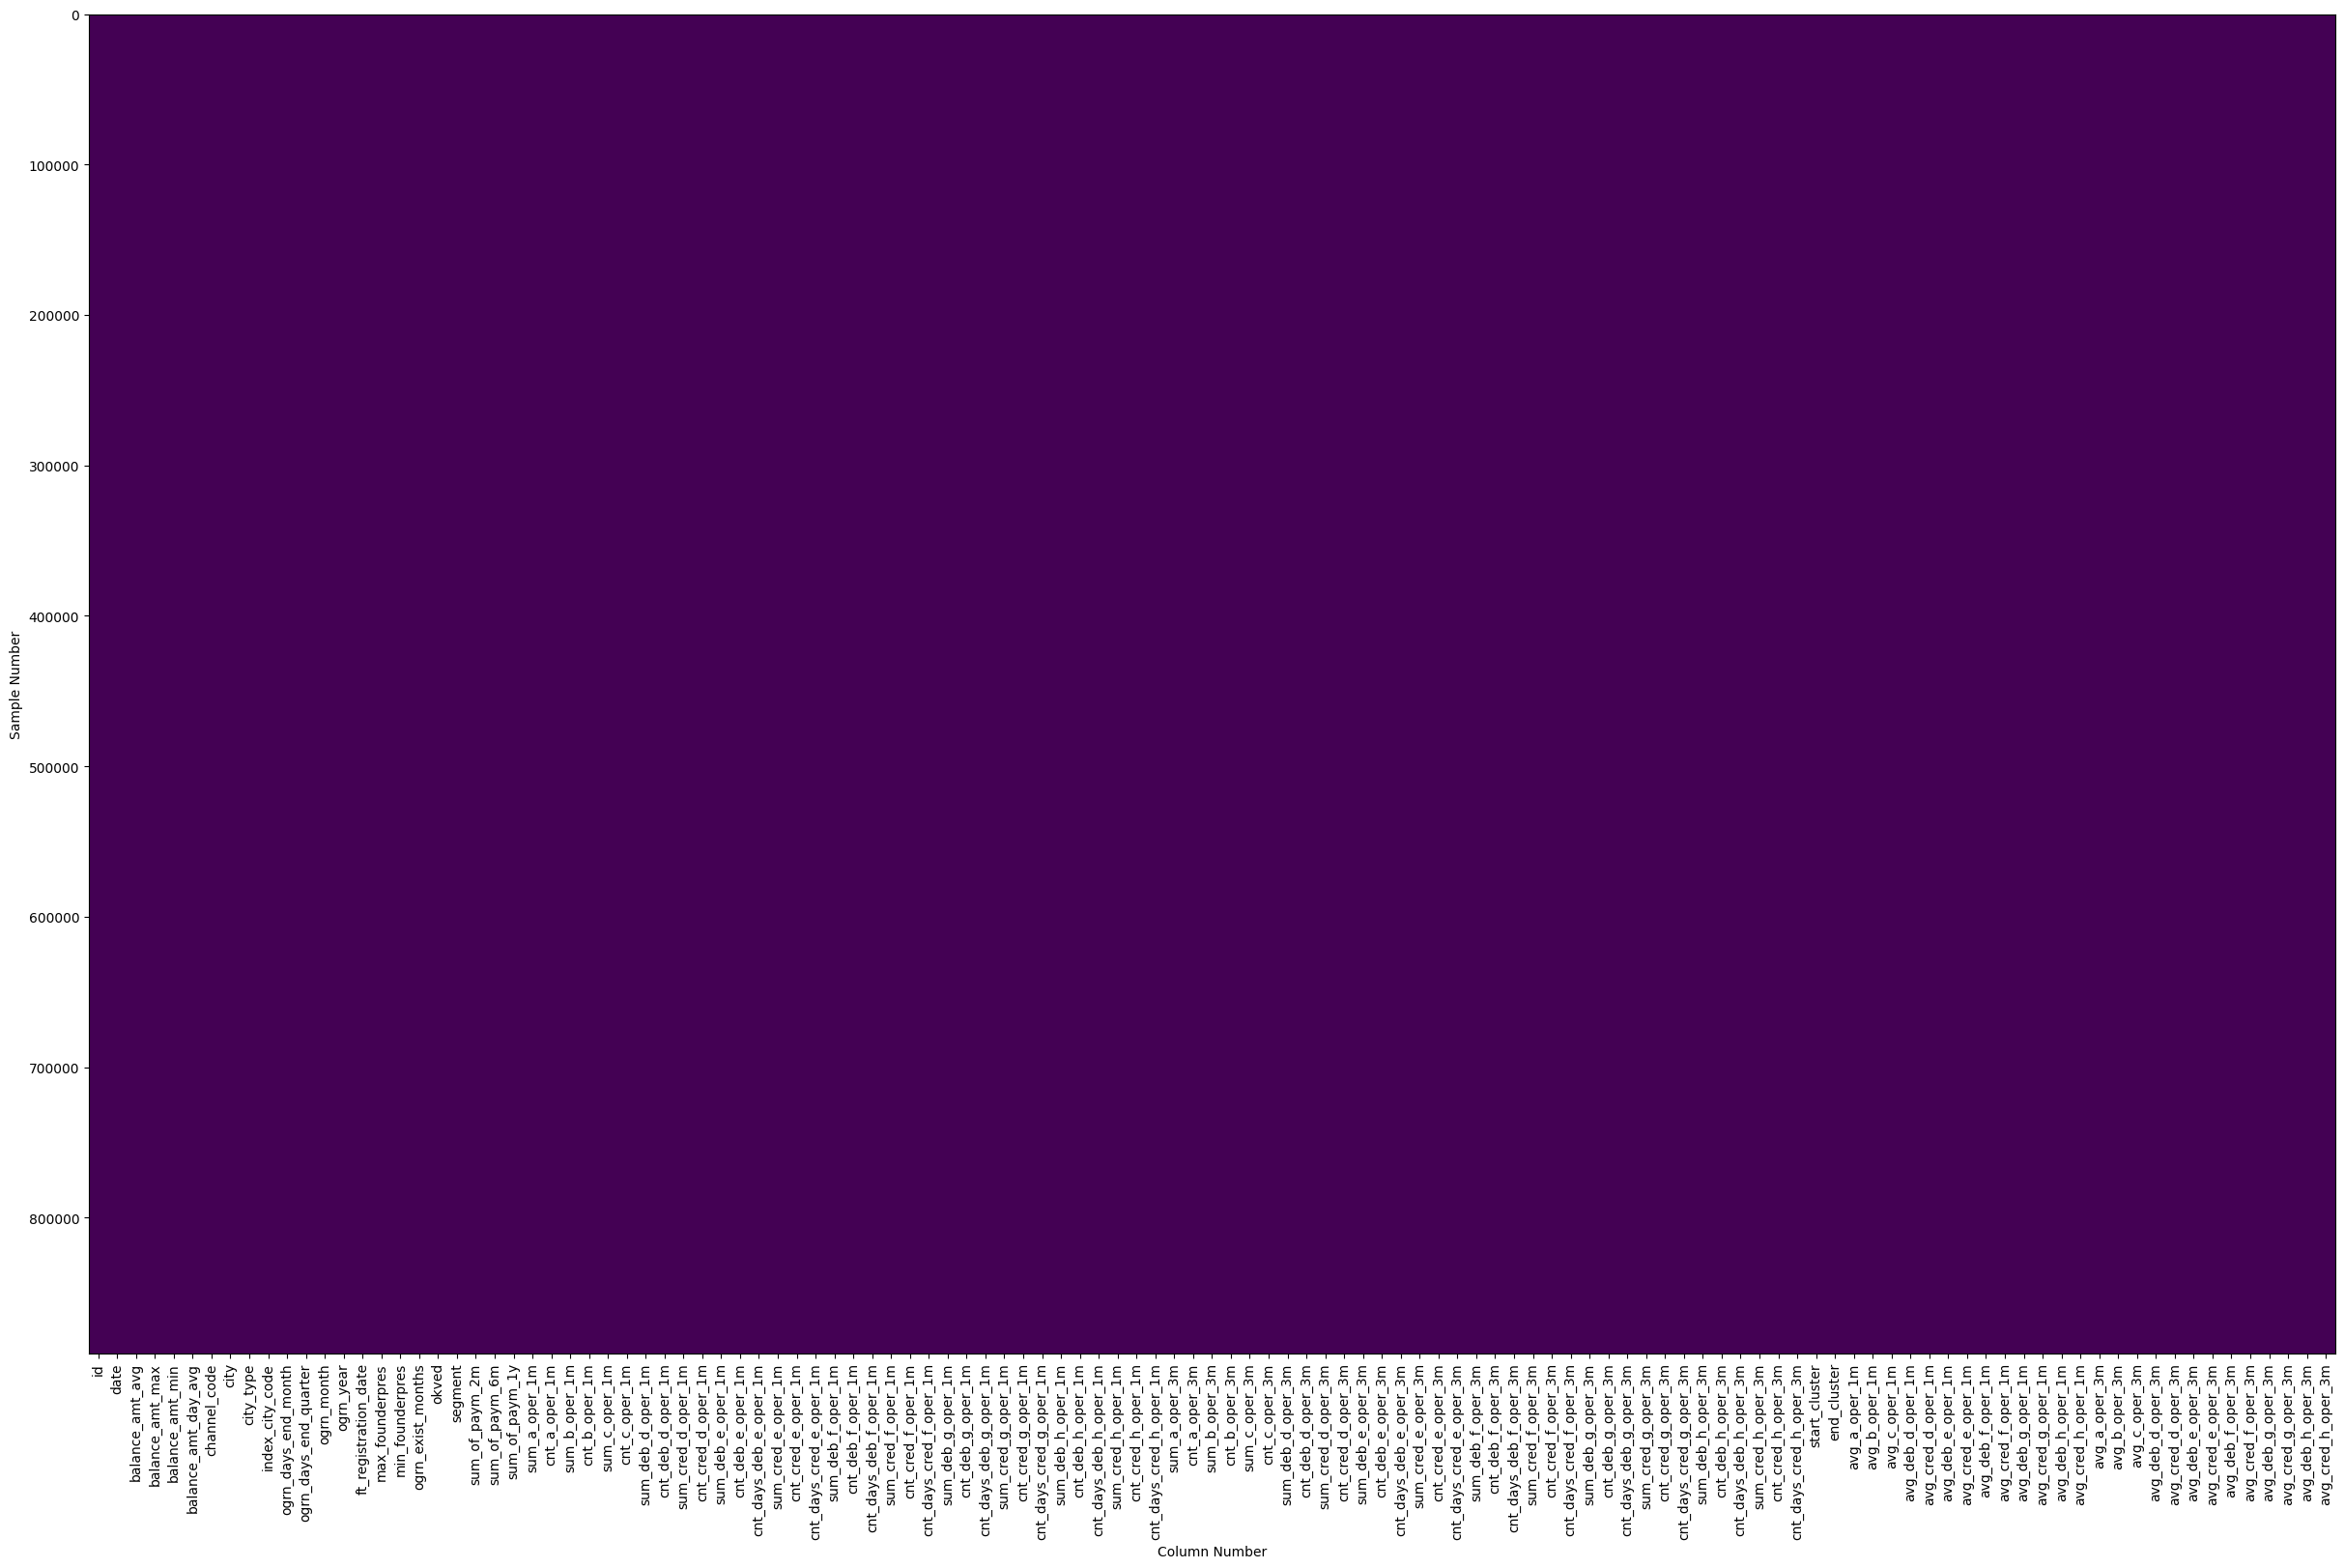

In [154]:
plt_null_df(df.isna())

In [51]:
df.to_parquet("df_after_cat_restore_fill_min.pqt")

In [106]:
df = pd.read_parquet("df_after_cat_restore_fill_min.pqt")

# df = pd.read_parquet("/kaggle/input/alfa-hackaton/df.pqt")

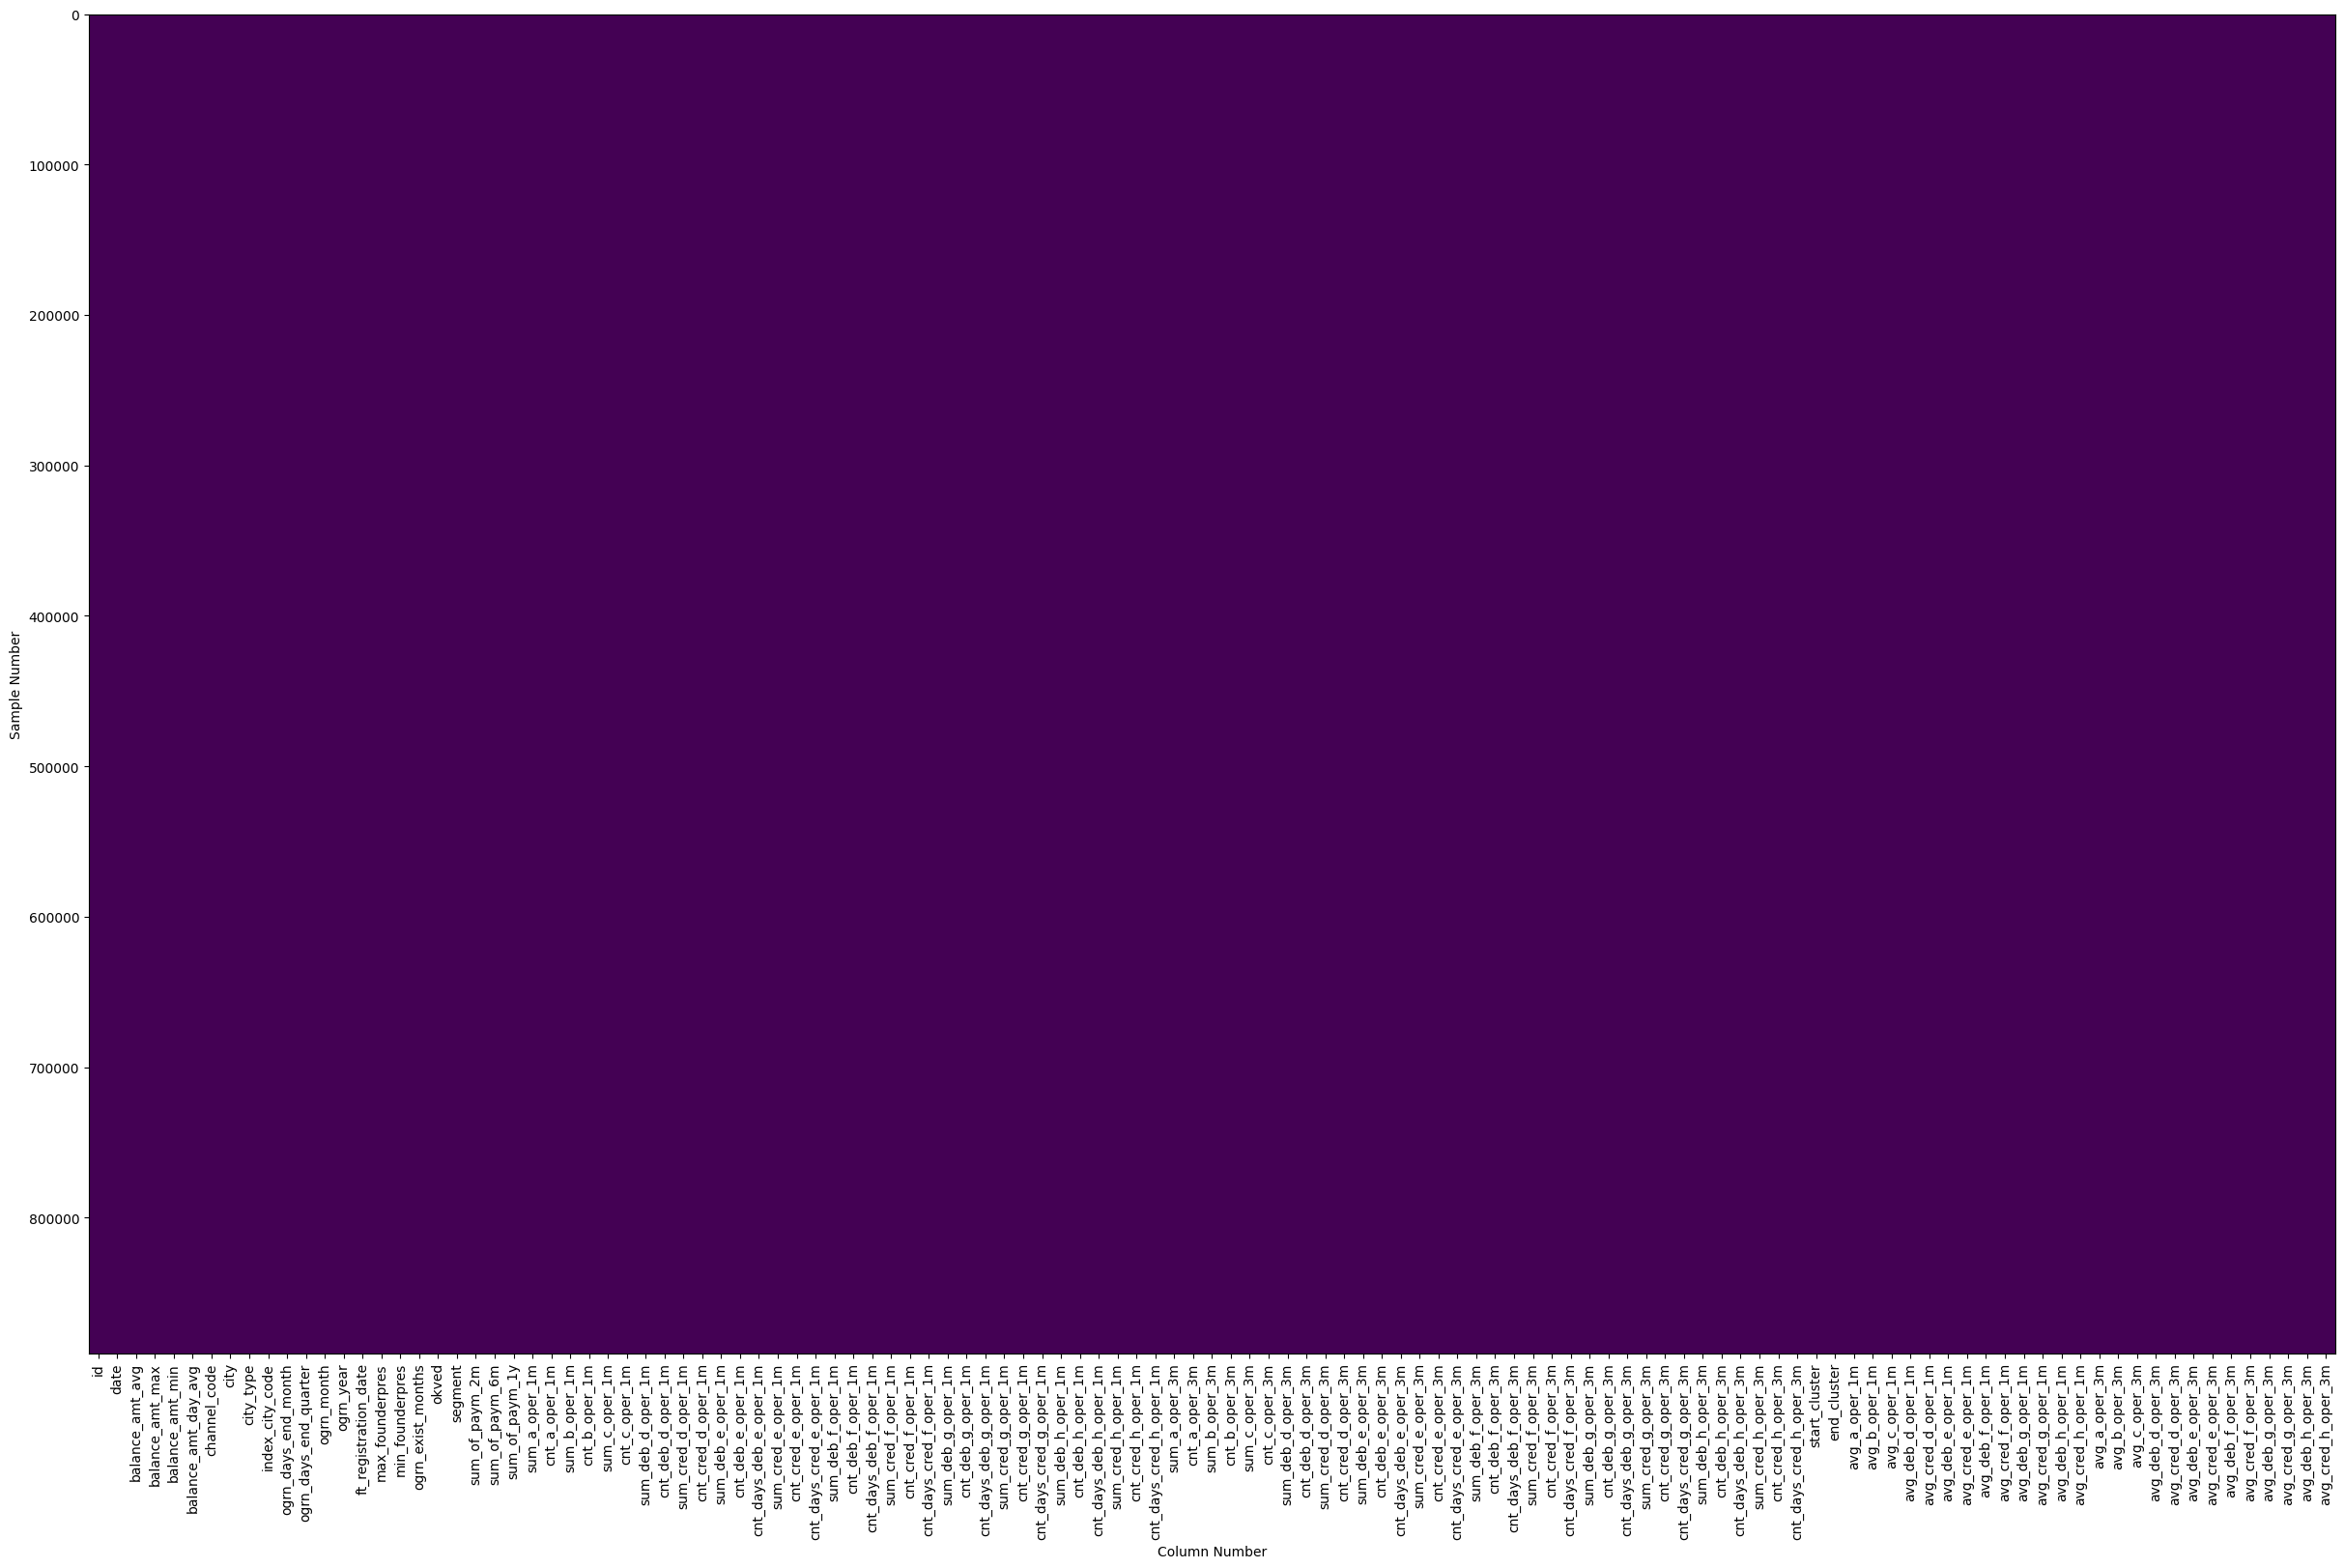

In [107]:
plt_null_df(df.isna())

In [149]:
# columns_to_drop = [
#     'balance_amt_max',
#     'balance_amt_min',
#     'balance_amt_day_avg',
#     'index_city_code',
#     'max_founderpres',
#     'min_founderpres',
#     'ogrn_exist_months',
#     'sum_a_oper_1m',
#     'sum_b_oper_1m',
#     'sum_c_oper_1m',
#     'sum_deb_d_oper_1m',
#     'sum_cred_d_oper_1m',
#     'sum_deb_e_oper_1m',
#     'sum_cred_e_oper_1m',
#     'sum_deb_f_oper_1m',
#     'sum_cred_f_oper_1m',
#     'sum_deb_g_oper_1m',
#     'sum_cred_g_oper_1m',
#     'sum_deb_h_oper_1m',
#     'sum_cred_h_oper_1m',
#     'sum_a_oper_3m',
#     'sum_b_oper_3m',
#     'sum_c_oper_3m',
#     'sum_deb_d_oper_3m',
#     'sum_cred_d_oper_3m',
#     'sum_deb_e_oper_3m',
#     'sum_cred_e_oper_3m',
#     'sum_deb_f_oper_3m',
#     'sum_cred_f_oper_3m',
#     'sum_deb_g_oper_3m',
#     'sum_cred_g_oper_3m',
#     'sum_deb_h_oper_3m',
#     'sum_cred_h_oper_3m']


# df = df.drop(columns=columns_to_drop)


columns_to_drop = [
    
    'index_city_code',
    'max_founderpres',
    'min_founderpres',
    'ogrn_exist_months',
]


df = df.drop(columns=columns_to_drop)

In [172]:
cat_cols = [
          "channel_code", "city", "city_type",
          "okved", "segment", "start_cluster", "ogrn_month", "ogrn_year",
      ]



df['date'] = df['date'].replace({'month_4': 'month_1', 'month_5': 'month_2', 'month_6': 'month_3'})

df[cat_cols] = df[cat_cols].astype("object")

### Создание таблицы с 3 месяцами

In [173]:
cat_cols = [
    "channel_code", "city", "city_type",
    "okved", "segment", "ogrn_month", "ogrn_year",
]

cat_cols_month_1 = [f'{col}_month_1' for col in cat_cols]
cat_cols_month_2 = [f'{col}_month_2' for col in cat_cols]



pivot_df = df.pivot_table(index='id', columns='date', aggfunc='first')

pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]

pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.drop(
    columns=['end_cluster_month_1', 'end_cluster_month_2'] + cat_cols_month_1 + cat_cols_month_2, axis=0)

categorical_columns = pivot_df.select_dtypes(include=['object']).columns
pivot_df[categorical_columns] = pivot_df[categorical_columns].fillna("missing")

In [157]:
df

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,avg_deb_d_oper_3m,avg_cred_d_oper_3m,avg_deb_e_oper_3m,avg_cred_e_oper_3m,avg_deb_f_oper_3m,avg_cred_f_oper_3m,avg_deb_g_oper_3m,avg_cred_g_oper_3m,avg_deb_h_oper_3m,avg_cred_h_oper_3m
0,0,month_1,0.7448,0.7055,1.2872,0.7481,channel_code_5,city_23,city_type_0,index_city_code_39,...,-0.1646,-0.2751,0.8369,0.5045,-0.5317,-0.1032,-0.0887,0.1964,1.6213,3.1640
1,0,month_2,1.0496,0.8319,2.4586,1.0538,channel_code_5,city_23,city_type_0,index_city_code_39,...,-0.1467,-0.2751,0.7095,0.4758,-0.4970,-0.1032,-0.0887,0.1318,1.4224,3.3130
2,0,month_3,0.6927,0.7403,0.4300,0.6957,channel_code_5,city_23,city_type_0,index_city_code_39,...,-0.1467,-0.2751,0.8142,0.3247,-0.4970,-0.1032,-0.0887,0.0355,1.5916,2.7476
3,1,month_1,-0.0816,-0.0919,-0.1140,-0.0809,channel_code_2,city_14,city_type_0,missing,...,0.1973,-0.2751,0.4489,0.2257,-0.6970,-0.1032,0.1113,-0.0260,0.6512,-0.7258
4,1,month_2,-0.0950,-0.1005,-0.1193,-0.0943,channel_code_2,city_14,city_type_0,missing,...,0.3113,-0.2751,0.1607,0.0689,-0.6813,-0.1032,0.1605,-0.0253,0.1201,-0.7195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890115,299998,month_2,-0.0067,-0.0068,-0.0065,-0.0068,channel_code_9,city_25,city_type_0,missing,...,-0.1643,-0.2744,-0.3590,-0.1812,-0.7463,-0.1032,-0.0881,-0.0302,-0.3004,-0.7877
890116,299998,month_3,-0.1553,-0.2037,-0.1260,-0.1560,channel_code_9,city_25,city_type_0,index_city_code_30,...,-0.1646,-0.2751,-0.3593,-0.1810,-0.7464,-0.1032,-0.0887,-0.0303,-0.3028,-0.8015
890117,299999,month_1,-0.1459,-0.1733,-0.1260,-0.1454,channel_code_9,city_6,city_type_0,index_city_code_34,...,-0.1646,-0.2751,-0.2815,-0.1387,-0.7464,-0.1032,-0.0887,-0.0303,-0.1772,-0.4012
890118,299999,month_2,-0.1364,-0.1639,-0.1215,-0.1359,channel_code_9,city_6,city_type_0,index_city_code_34,...,-0.1646,-0.2751,-0.2164,-0.1104,-0.7464,-0.1032,-0.0735,-0.0303,-0.0863,-0.1375


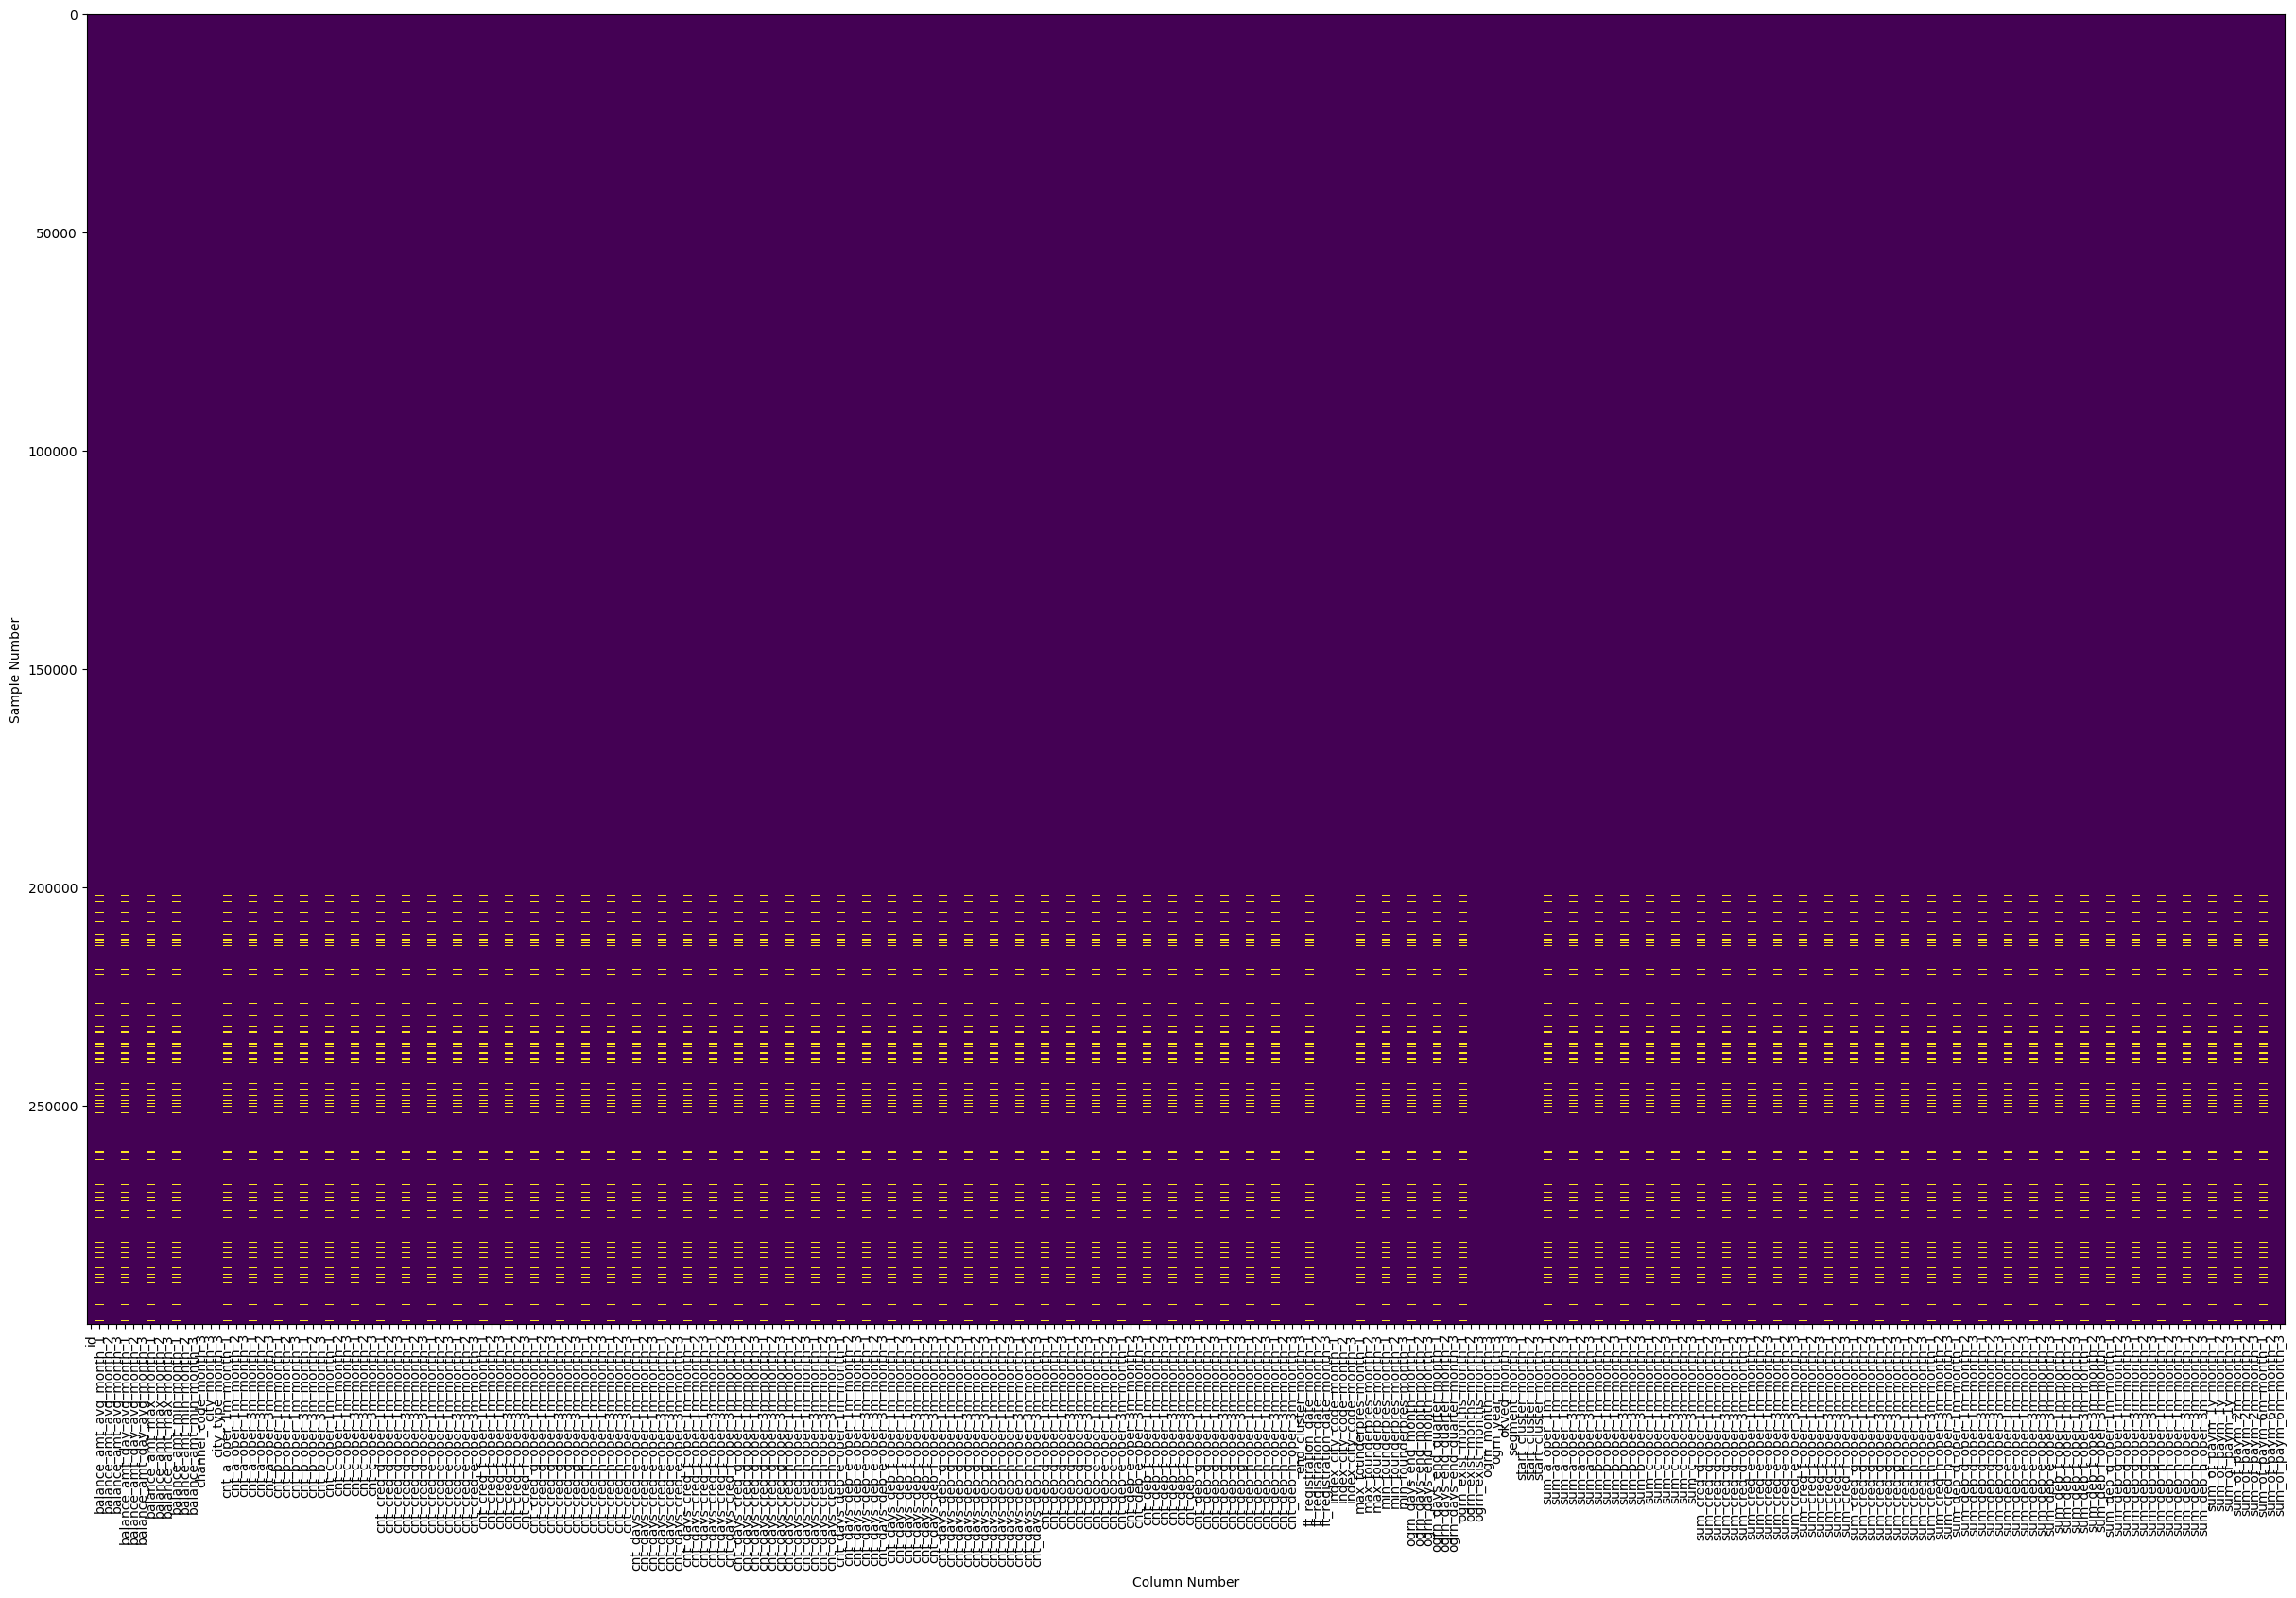

In [139]:
### появляются пропуски потому у кого нет 3 или 4 месяца

plt_null_df(pivot_df.isna()) 

In [118]:
for column in pivot_df.select_dtypes(include=['number']).columns[1:]:  
    pivot_df[column] = pivot_df.groupby('okved_month_3')[column].transform(lambda x: x.fillna(x.mean()))

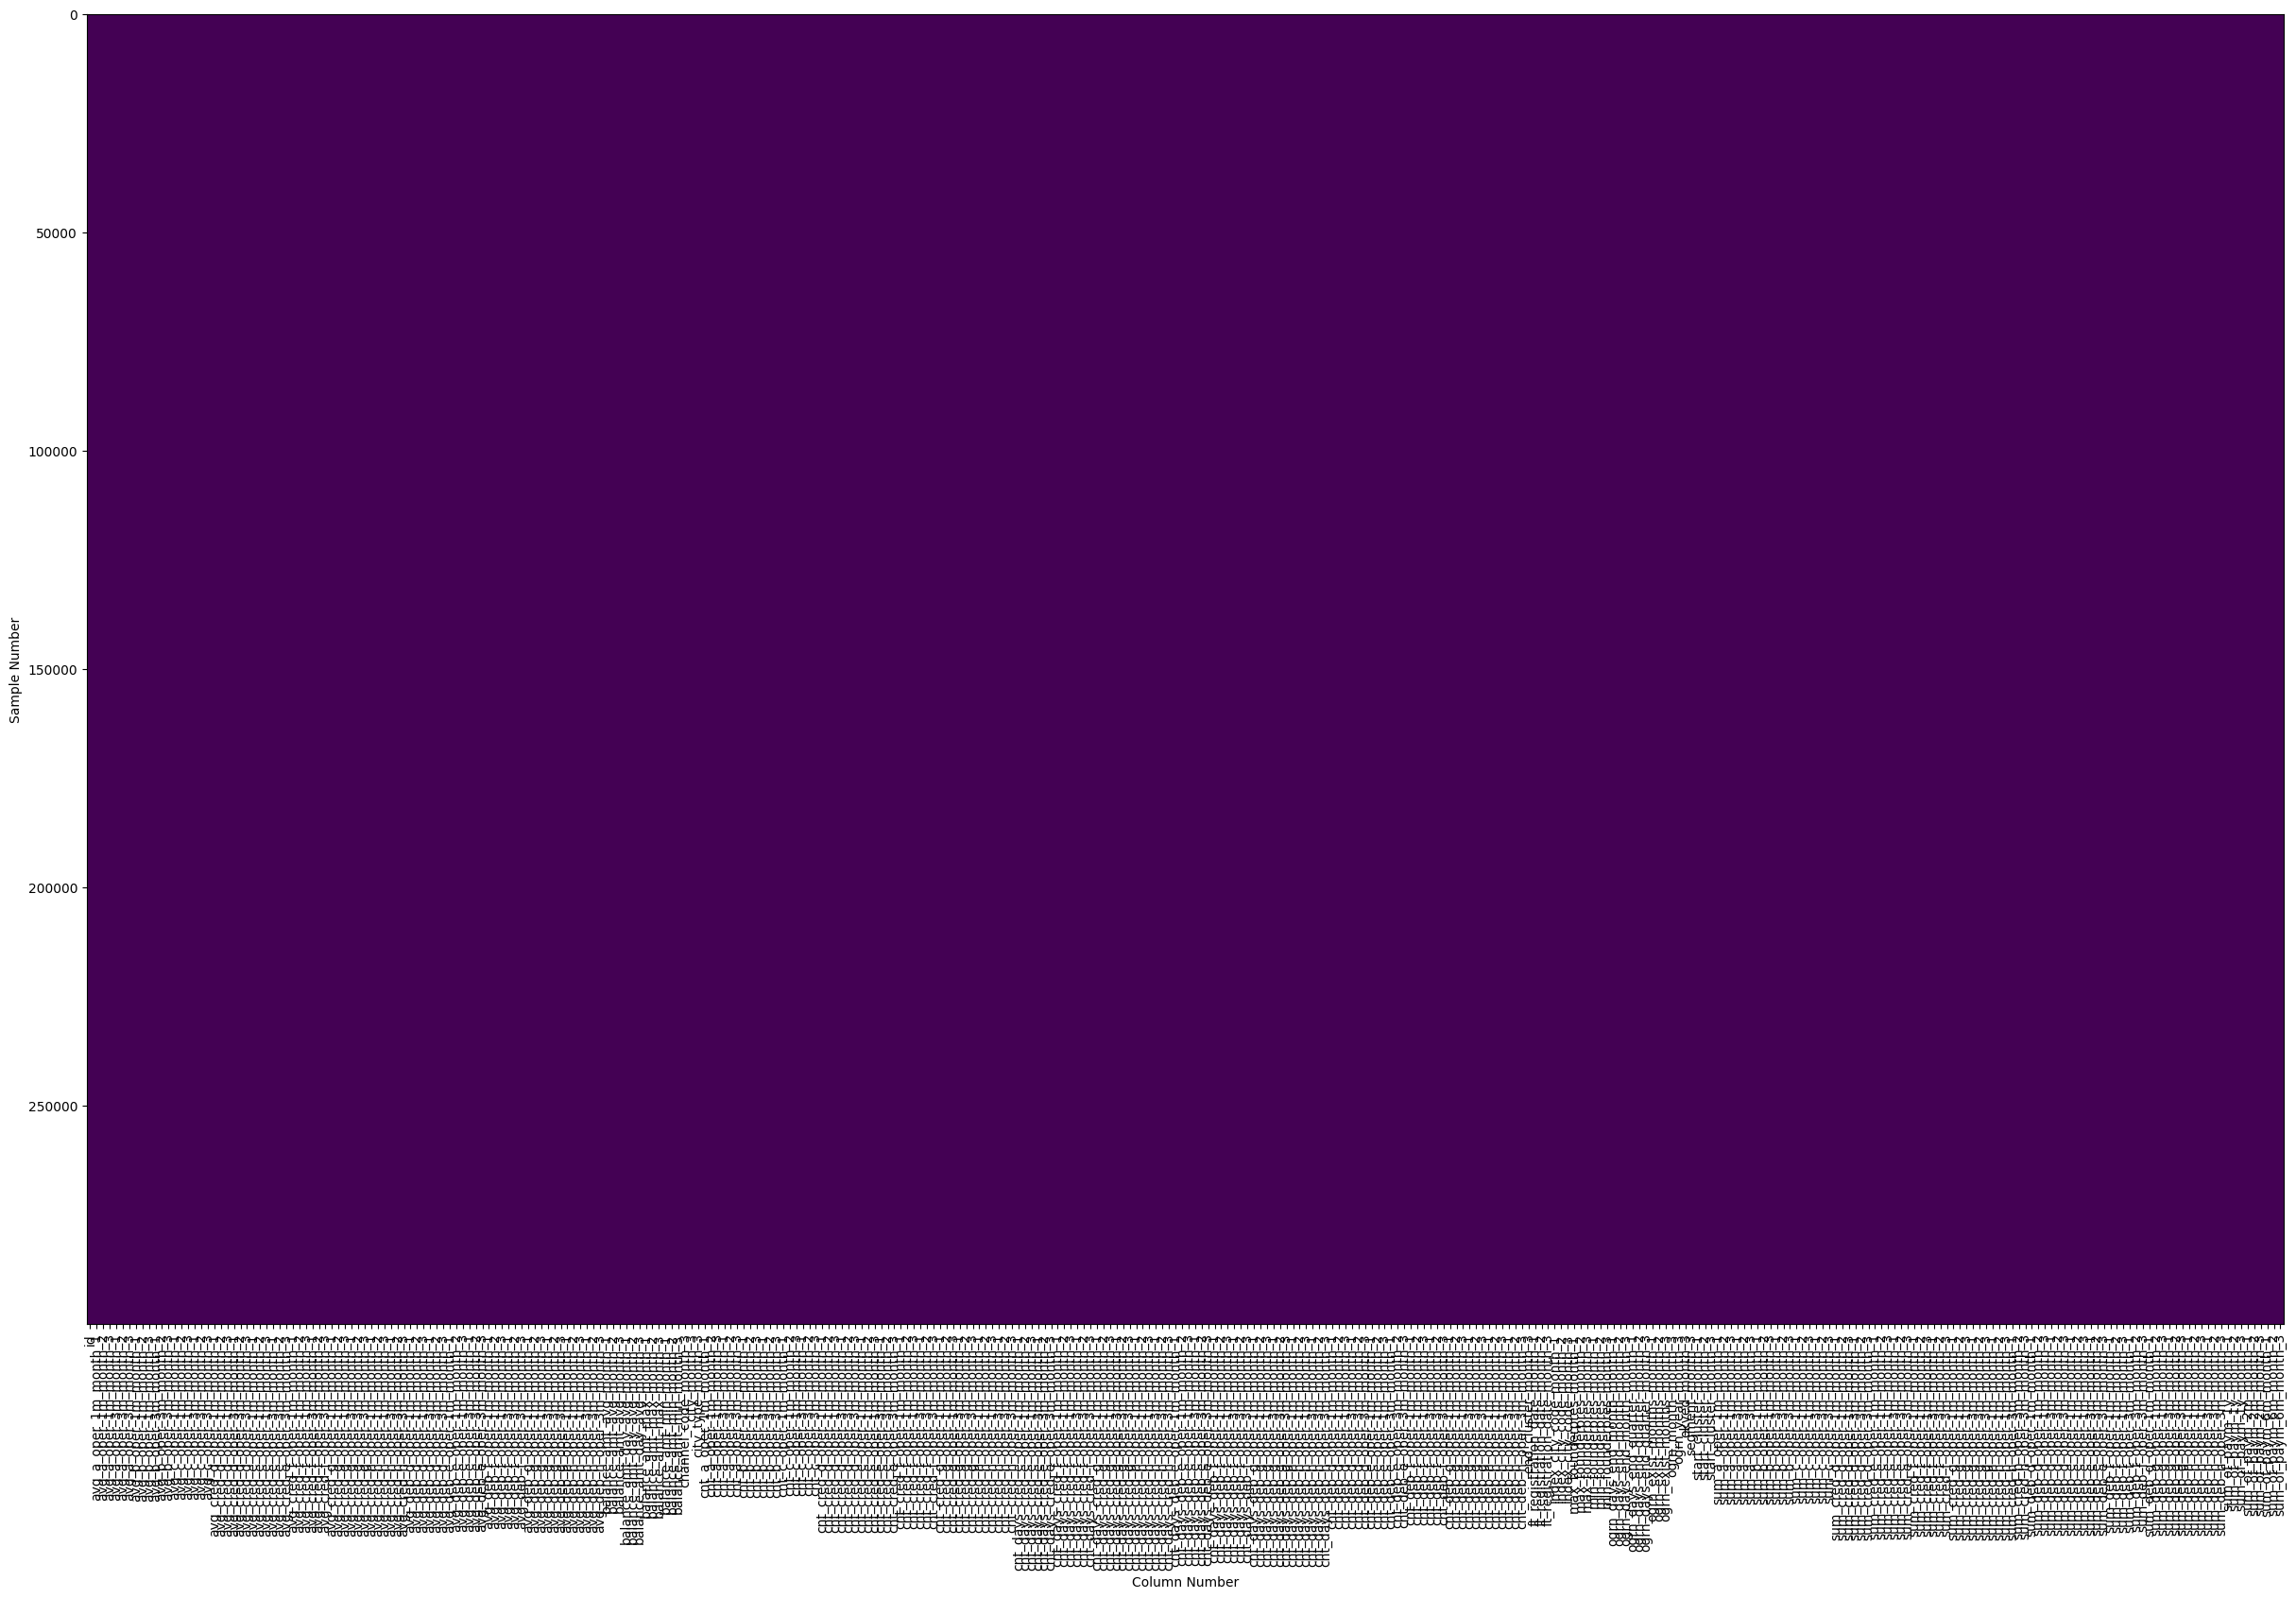

In [119]:
plt_null_df(pivot_df.isna()) 

In [174]:
numeric_cols = pivot_df.select_dtypes(include=['number']).columns[1:]

for i in range(0,len(numeric_cols) - 2,3):
    col1 = numeric_cols[i]
    col2 = numeric_cols[i + 1]
    col3 = numeric_cols[i + 2]

    col_name = "-".join(col1.split("_")[:-2])

    pivot_df[f'{col_name}_diff_2_1'] = pivot_df[col2] - pivot_df[col1]

    pivot_df[f'{col_name}_diff_3_2'] = pivot_df[col3] - pivot_df[col2]
    
    pivot_df[f'{col_name}_mean'] = pivot_df[[col1, col2, col3]].mean(axis=1)
    

    
# Сумма колличества операций
cnt_columns = [col for col in df.columns if col.startswith('cnt')]
df['all_cnt'] = df[cnt_columns].sum(axis=1)

# Сумма операций 
cnt_columns = [col for col in df.columns if col.startswith('sum')]
df['all_sum'] = df[cnt_columns].sum(axis=1)

In [202]:
# numeric_cols = pivot_df.select_dtypes(include=['number']).columns
# for col in numeric_cols:
#     min_val = pivot_df[col].mean()
#     pivot_df[col].fillna(min_val, inplace=True)
    

In [68]:
# def remove_outliers(df, k=1.5):
#     # Создаем копию DataFrame, чтобы избежать изменения исходного DataFrame
#     df_cleaned = df.copy()

#     # Итерируемся по каждому числовому столбцу
#     for column in df_cleaned.select_dtypes(include='number').columns:
#         # Вычисляем квартили
#         Q1 = df_cleaned[column].quantile(0.25)
#         Q3 = df_cleaned[column].quantile(0.75)

#         # Вычисляем межквартильный размах (IQR)
#         IQR = Q3 - Q1

#         # Определяем верхнюю и нижнюю границы для выбросов
#         lower_bound = Q1 - k * IQR
#         upper_bound = Q3 + k * IQR

#         # Заменяем значения за пределами границ на минимальное и максимальное значение
#         df_cleaned[column] = df_cleaned[column].clip(
#             lower=lower_bound, upper=upper_bound)

#     return df_cleaned


# # Применяем функцию к DataFrame, чтобы избавиться от выбросов
# df = remove_outliers(df)

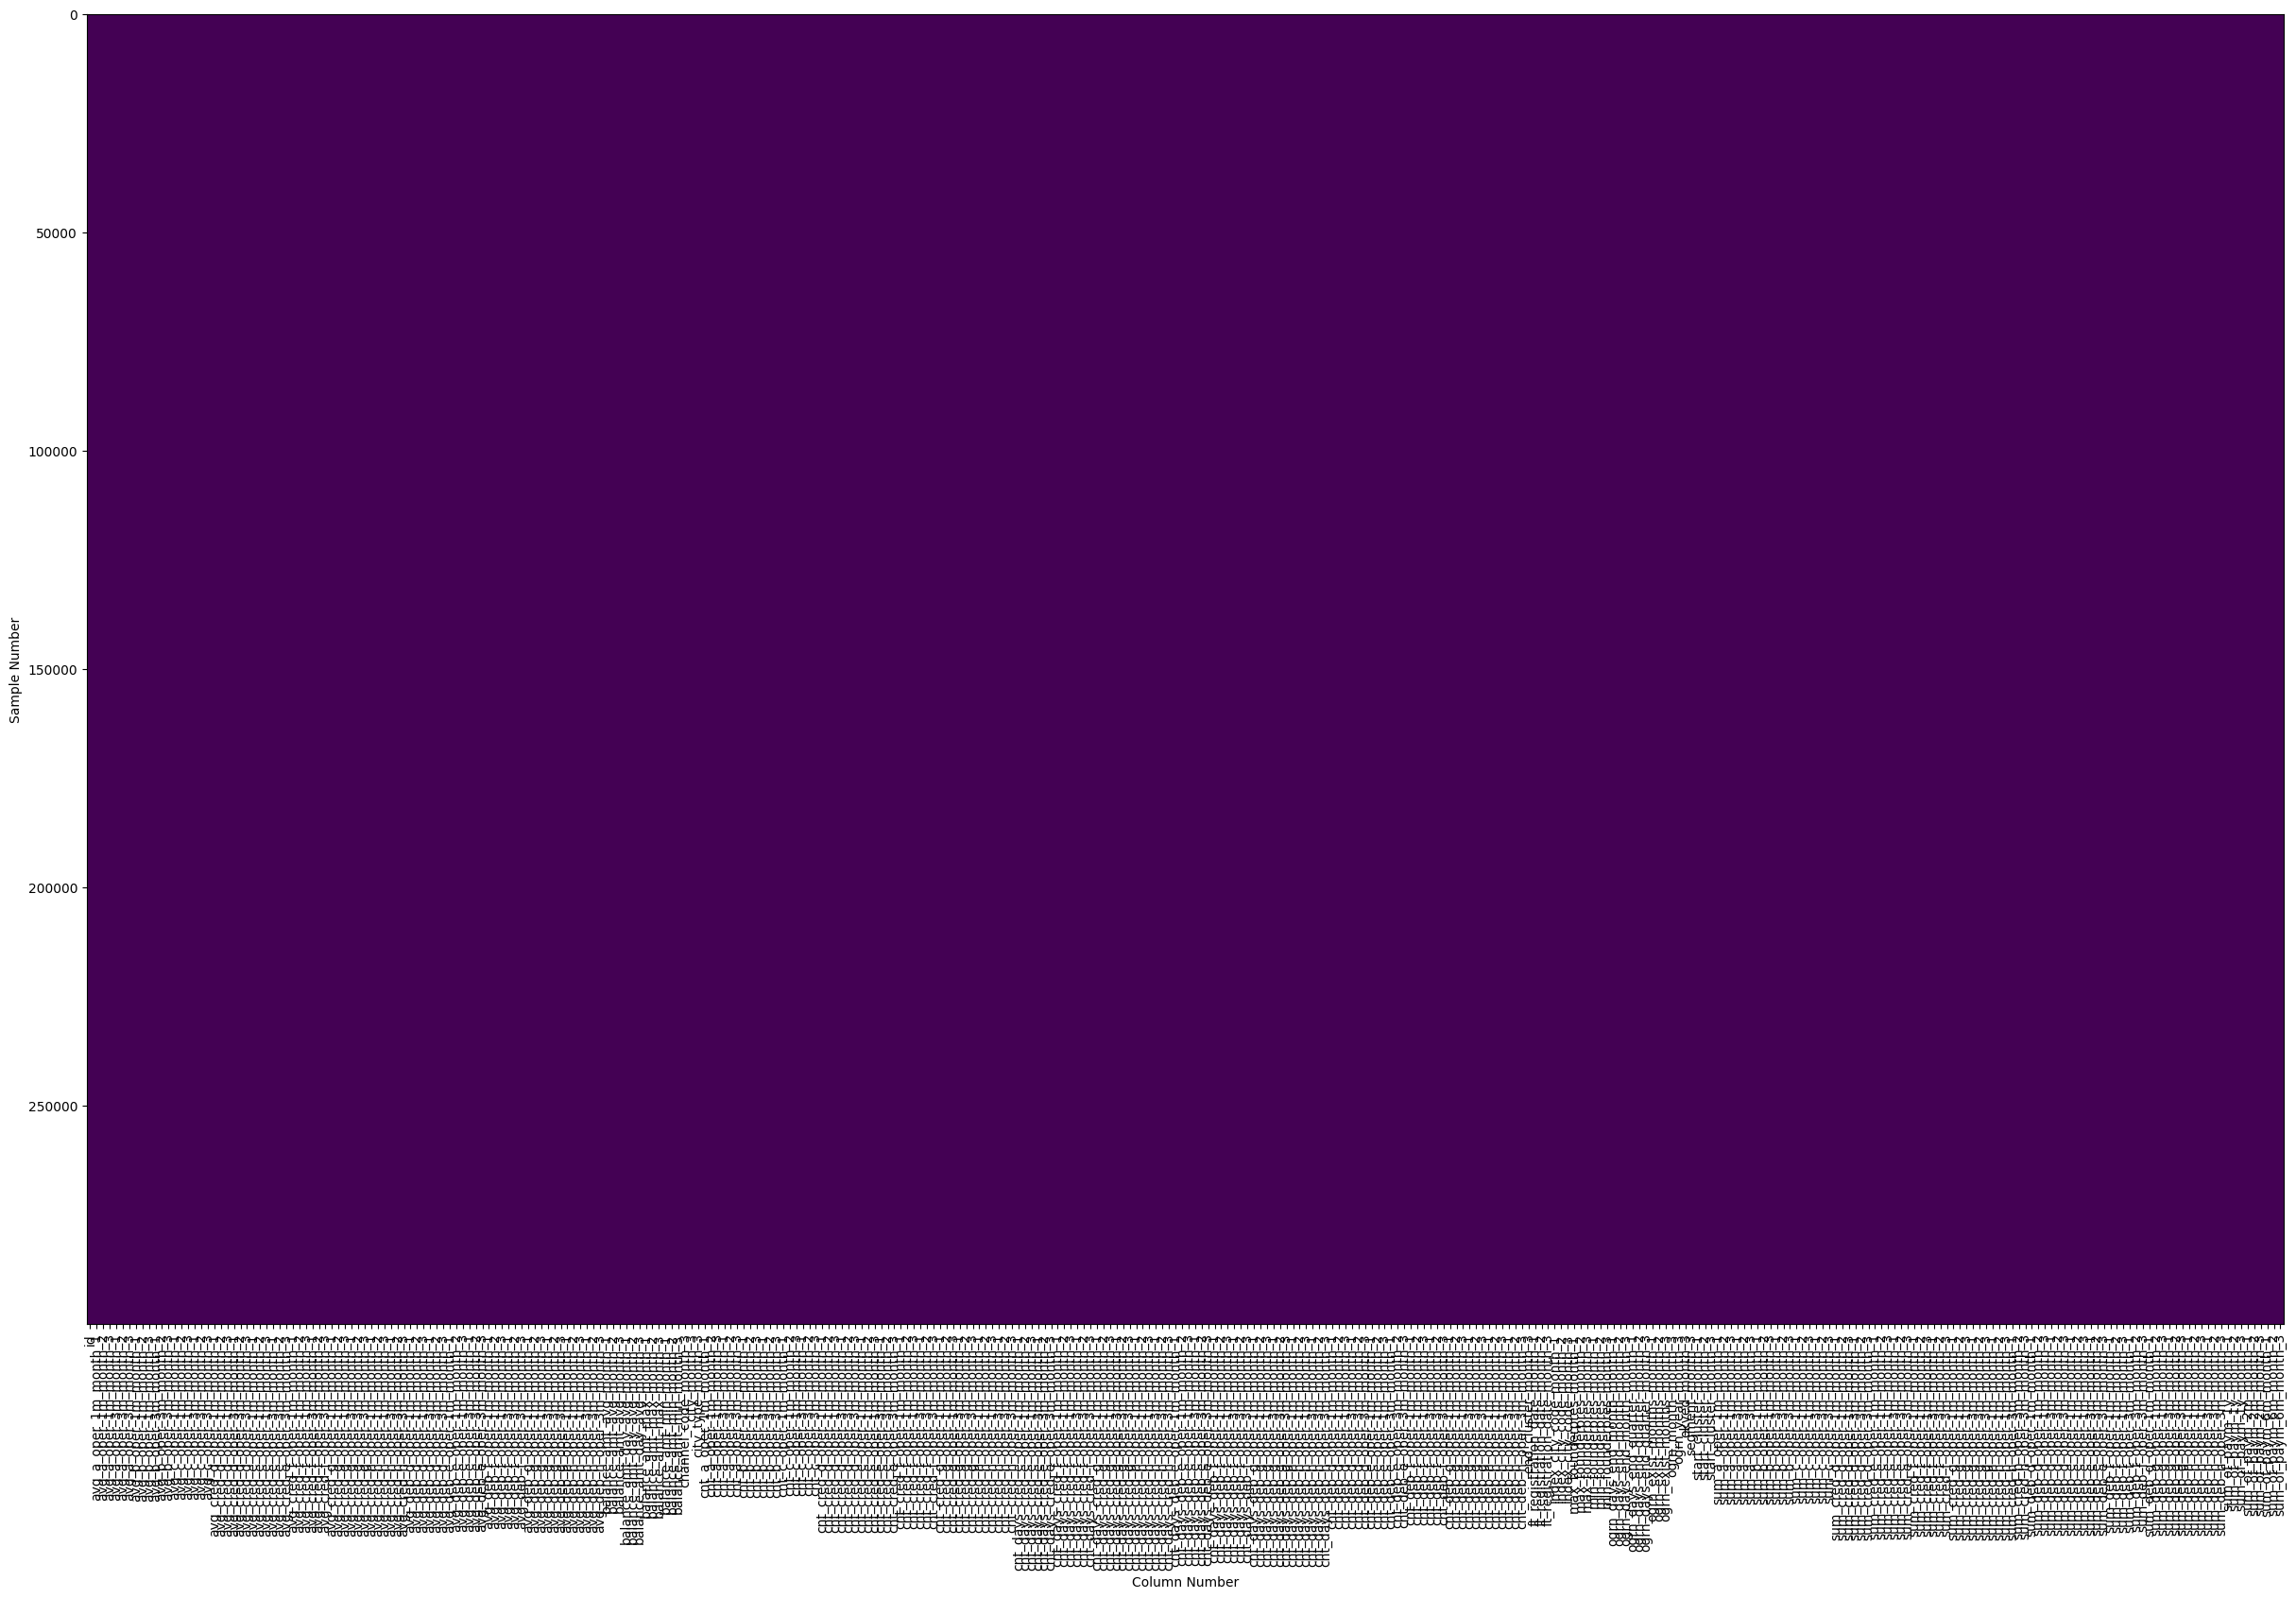

In [69]:
plt_null_df(pivot_df.isna())

In [177]:
df = pivot_df

### Воостановление start_claster

In [178]:
train_data = df[df['start_cluster_month_3'] != 'missing'].drop(
    ['id',  'end_cluster_month_3'], axis=1)
predict_data = df[df['start_cluster_month_3'] == 'missing'].drop(
    ['id', 'end_cluster_month_3'], axis=1)



# label_encoders = {}

# for col in cat_names:
#     label_encoders[col] = LabelEncoder().fit(df[col]) # !!!!!!!!!!!!!!!!!!

#     train_data[col] = label_encoders[col].transform(train_data[col])
#     predict_data[col] = label_encoders[col].transform(predict_data[col])
    
    

X = train_data.drop('start_cluster_month_3', axis=1)
y = train_data['start_cluster_month_3']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [160]:
# # Определение желаемого количества экземпляров каждого класса
# desired_class_count = 750  # Укажите ваше желаемое количество экземпляров

# # Обработка дисбаланса классов
# balanced_data = pd.DataFrame()
# for cluster in train_data['start_cluster_month_3'].unique():
#     cluster_data = train_data[train_data['start_cluster_month_3'] == cluster]
#     if len(cluster_data) < desired_class_count:
#         resampled_data = resample(
#             cluster_data, replace=True, n_samples=desired_class_count, random_state=42)
#     else:
#         resampled_data = cluster_data.sample(
#             n=desired_class_count, replace=False, random_state=42)
#     balanced_data = pd.concat([balanced_data, resampled_data])
# display(balanced_data['start_cluster_month_3'].value_counts())



# X = balanced_data.drop('start_cluster_month_3', axis=1)
# y = balanced_data['start_cluster_month_3']

# categorical_columns = X.select_dtypes(include=['object']).columns
# X[categorical_columns] = X[categorical_columns].fillna("missing")


#### CATBOOST

In [179]:
catboost_model_start_cluster = CatBoostClassifier(iterations=1024,
                           depth=6,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                           )

In [180]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):

    model.fit(
        x_train, y_train,
        cat_features=np.array(cat_names),
        eval_set=(x_val, y_val),
        verbose=100  # через сколько итераций выводить стату
    )
    model.save_model('catboost_model_start_cluster.json')  # сохранение модели
    feature_importance = model.get_feature_importance(
        prettified=True)  # датасет с важностью признаков

    return feature_importance

In [181]:
cat_names = X.select_dtypes(include=['object']).columns

feature_importance = train_catboost(
    catboost_model_start_cluster, X_train, y_train, X_val, y_val, cat_names)

0:	learn: 1.9052936	test: 1.8940256	best: 1.8940256 (0)	total: 195ms	remaining: 3m 19s
100:	learn: 0.2468888	test: 0.2273373	best: 0.2273373 (100)	total: 10.6s	remaining: 1m 37s
200:	learn: 0.2281367	test: 0.2157886	best: 0.2157886 (200)	total: 20.1s	remaining: 1m 22s
300:	learn: 0.2217243	test: 0.2124025	best: 0.2123995 (298)	total: 28.6s	remaining: 1m 8s
400:	learn: 0.2173896	test: 0.2105098	best: 0.2105098 (400)	total: 36.8s	remaining: 57.2s
500:	learn: 0.2144046	test: 0.2093972	best: 0.2093972 (500)	total: 44.9s	remaining: 46.9s
600:	learn: 0.2111488	test: 0.2082608	best: 0.2082608 (600)	total: 53.2s	remaining: 37.4s
700:	learn: 0.2085062	test: 0.2076245	best: 0.2076245 (700)	total: 1m 1s	remaining: 28.3s
800:	learn: 0.2058790	test: 0.2069991	best: 0.2069991 (800)	total: 1m 9s	remaining: 19.4s
900:	learn: 0.2035556	test: 0.2065942	best: 0.2065937 (898)	total: 1m 18s	remaining: 10.7s
1000:	learn: 0.2009423	test: 0.2058031	best: 0.2057996 (999)	total: 1m 26s	remaining: 1.99s
1023:	le

In [182]:
feature_importance

,Feature Id,Importances
0,start_cluster_month_2,29.9880
1,ogrn-exist-months_diff_2_1,3.4946
2,okved_month_3,2.6305
3,balance_amt_min_month_3,2.6056
4,avg_b_oper_3m_month_3,1.9528
...,...,...
649,sum-c-oper-1m_mean,0.0000
650,sum-cred-d-oper-1m_mean,0.0000
651,sum-cred-d-oper-3m_mean,0.0000
652,sum-cred-f-oper-1m_mean,0.0000


### lgb

In [76]:
# params_lgb = {
#     'objective': 'multiclass',
#     'num_class':17,
#     'metric': 'roc-auc',
#     'n_estimators': 500,
#     'class_weight': 'balanced',
#     'random_state': 47}

# model_lgb = LGBMClassifier(**params_lgb)

# verbose_eval = 50  # Определяет, как часто выводить метрики на валидационном наборе

# # Обучаем модель
# lgb_model = lgb.LGBMClassifier(**lgb_params, n_estimators=1024, device='gpu', early_stopping_rounds=20, verbose_eval=verbose_eval,  verbose=-1)

# lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])



In [183]:
y_pred = catboost_model_start_cluster.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

     {other}       0.93      0.92      0.92      2432
          {}       0.88      0.86      0.87      3847
      {α, β}       0.91      0.93      0.92       710
      {α, γ}       0.93      0.92      0.93      2274
      {α, δ}       0.86      0.86      0.86       575
   {α, ε, η}       0.91      0.89      0.90       125
   {α, ε, θ}       0.86      0.83      0.85        53
   {α, ε, ψ}       0.85      0.83      0.84        35
      {α, ε}       0.90      0.85      0.87       369
      {α, η}       0.96      0.97      0.97      3651
      {α, θ}       0.91      0.88      0.89       322
      {α, λ}       0.75      0.84      0.79        67
      {α, μ}       0.84      0.84      0.84        93
      {α, π}       0.00      0.00      0.00         1
      {α, ψ}       0.94      0.92      0.93       331
         {α}       0.96      0.97      0.97     25112
         {λ}       1.00      0.33      0.50         3

    accuracy              

In [184]:
X_predict = predict_data.drop('start_cluster_month_3', axis=1)
predicted_clusters = catboost_model_start_cluster.predict(X_predict)

In [185]:
predicted_clusters_flat = np.ravel(predicted_clusters)
class_counts = pd.Series(predicted_clusters_flat).value_counts()
print(class_counts)

{α}          67750
{α, η}        8455
{}            6720
{other}       5726
{α, γ}        5143
{α, β}        2001
{α, δ}        1349
{α, ε}         845
{α, θ}         764
{α, ψ}         462
{α, μ}         271
{α, ε, η}      199
{α, λ}         150
{α, ε, θ}      113
{α, ε, ψ}       44
{λ}              8
Name: count, dtype: int64


In [ ]:
predicted_index = 0

df_restore_start_cluster = df.copy()
for index, row in df_restore_start_cluster.iterrows():
    # Проверяем, содержится ли в столбце 'date' значение 'month6' и id >= 100000
    if row['id'] >= 200000:
        # Вставляем значение из серии в столбец 'start_cluster_month_3' текущей строки
        df_restore_start_cluster.at[index,
                                    'start_cluster_month_3'] = predicted_clusters[predicted_index][0]
        # Увеличиваем индекс текущей строки в серии
        predicted_index += 1

In [ ]:
matching_rows = df_restore_start_cluster[df_restore_start_cluster['id'] >= 200000].loc[(df_restore_start_cluster['start_cluster_month_1'] == df_restore_start_cluster['start_cluster_month_2']) & (
    df_restore_start_cluster['start_cluster_month_2'] == df_restore_start_cluster['start_cluster_month_3'])]
matching_rows

In [ ]:
df.to_parquet("df_after_start_restore.pqt")

In [ ]:
plt_null_df(df_restore_start_cluster.isna())

## Обучение модели <a class="anchor" id="first-bullet"></a>

In [ ]:
train_df = df_restore_start_cluster[df_restore_start_cluster['id']< 200000]
test_df = df_restore_start_cluster[df_restore_start_cluster['id'] >= 200000]

X = train_df.drop(["id"], axis=1) # оставляю end_cluster чтобы получить пропорцию классов, а потом ниже удалю в коде
y = train_df["end_cluster_month_3"]

x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [ ]:
x_train['end_cluster_month_3'].value_counts()

In [ ]:
y_train = x_train['end_cluster_month_3']
x_train = x_train.drop(['end_cluster_month_3'], axis=1)
x_val = x_val.drop(['end_cluster_month_3'], axis=1)

display(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

In [ ]:
catboost_model_end_cluster = CatBoostClassifier(iterations=2025,
                           depth=4,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                          )


In [ ]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):

    model.fit(
    x_train, y_train,
    cat_features=np.array(cat_names),
    eval_set=(x_val, y_val),
    verbose=100 # через сколько итераций выводить стату
    )
    model.save_model('catboost_model_end_claster.json') # сохранение модели
    feature_importance = model.get_feature_importance(prettified=True) # датасет с важностью признаков

    return feature_importance

In [ ]:
cat_names = x_train.select_dtypes(include=['object']).columns



feature_importance = train_catboost(catboost_model_end_cluster, x_train, y_train, x_val, y_val, cat_names)

In [97]:
feature_importance

,Feature Id,Importances
0,start_cluster_month_3,12.3474
1,segment_month_3,3.1867
2,city_month_3,2.8112
3,okved_month_3,2.5965
4,start_cluster_month_1,2.4973
...,...,...
329,cnt_deb_f_oper_3m_month_2,0.0000
330,sum_a_oper_3m_month_2,0.0000
331,sum_b_oper_3m_month_2,0.0000
332,sum_cred_d_oper_1m_month_1,0.0000


## Тестирование модели

In [98]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [99]:
cluster_weights = pd.read_excel("/kaggle/input/alfa-hackaton/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [100]:
y_pred_proba = catboost_model_end_cluster.predict_proba(x_val)
weighted_roc_auc(y_val, y_pred_proba, catboost_model_end_cluster.classes_, weights_dict)

0.9155436172659496

Прогноз на тестовой выборке

In [101]:
sample_submission_df = pd.read_csv("/kaggle/input/alfa-hackaton/sample_submission.csv") # поменять на свой
last_m_test_df = test_df
last_m_test_df = last_m_test_df.drop(["id" , 'end_cluster_month_3'], axis=1)

pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

test_pred_proba = catboost_model_end_cluster.predict_proba(pool2) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=catboost_model_end_cluster.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_10.csv", index=False) # сохранение модели

In [182]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.0163,0.6277,0.0038,0.0075,0.0027,0.0006,0.0018,0.0011,0.0014,0.0056,0.0073,0.0003,0.0014,0.0001,0.0021,0.3203,0.0002
1,200001,0.0192,0.4915,0.0021,0.0056,0.0014,0.0014,0.0014,0.0002,0.0009,0.0094,0.0024,0.0014,0.0027,0.0000,0.0015,0.4587,0.0001
2,200002,0.1238,0.3868,0.0057,0.0295,0.0044,0.0010,0.0034,0.0052,0.0038,0.0180,0.0053,0.0040,0.0015,0.0003,0.0132,0.3934,0.0007
3,200003,0.0323,0.4372,0.0015,0.0029,0.0013,0.0032,0.0012,0.0003,0.0015,0.0451,0.0036,0.0001,0.0022,0.0000,0.0016,0.4657,0.0000
4,200004,0.0841,0.4836,0.0024,0.0108,0.0019,0.0010,0.0002,0.0005,0.0029,0.0260,0.0017,0.0011,0.0097,0.0001,0.0016,0.3723,0.0002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.0378,0.3438,0.0126,0.0146,0.0081,0.0003,0.0010,0.0002,0.0017,0.0047,0.0026,0.0011,0.0014,0.0000,0.0041,0.5657,0.0002
99996,299996,0.0320,0.4433,0.0075,0.0168,0.0057,0.0003,0.0005,0.0005,0.0022,0.0050,0.0092,0.0020,0.0015,0.0000,0.0032,0.4700,0.0003
99997,299997,0.0167,0.3121,0.0051,0.0137,0.0055,0.0004,0.0013,0.0013,0.0025,0.0097,0.0063,0.0006,0.0018,0.0001,0.0055,0.6173,0.0002
99998,299998,0.0342,0.5481,0.0057,0.0168,0.0023,0.0004,0.0004,0.0005,0.0028,0.0053,0.0039,0.0038,0.0029,0.0001,0.0035,0.3689,0.0004


In [ ]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale',StandardScaler())
])
cat_pipeline = Pipeline(steps=[
    ('impute', restore_categorical_columns),)
])



# Шаги предобработки данных
preprocessing_steps = Pipeline([
    ('restore_categorical', FunctionTransformer(restore_categorical_columns)),
    ('impute_missing', SimpleImputer(strategy='mean', missing_values=pd.NA)),
    ('add_features', AddNewFeatures()),
    # Добавьте другие шаги предобработки данных здесь
])

# Пайплайн для обучения модели start_cluster
pipeline_start_cluster = Pipeline([
    ('preprocessing', preprocessing_steps),
    ('model', CatBoostClassifier(iterations=1024,
                                  depth=6,
                                  learning_rate=0.075,
                                  random_seed=47,
                                  loss_function='MultiClass',
                                  task_type="GPU",
                                  devices='0',
                                  early_stopping_rounds=20))
])

# Пайплайн для обучения модели end_cluster
pipeline_end_cluster = Pipeline([
    ('preprocessing', preprocessing_steps),
    ('model', CatBoostClassifier(iterations=2025,
                                  depth=4,
                                  learning_rate=0.075,
                                  random_seed=47,
                                  loss_function='MultiClass',
                                  task_type="GPU",
                                  devices='0',
                                  early_stopping_rounds=20))
])

# Разделение данных на обучающий и тестовый наборы
X = df.drop(["start_cluster_month_3", "end_cluster_month_3", "id"], axis=1)
y_start_cluster = df["start_cluster_month_3"]
y_end_cluster = df["end_cluster_month_3"]
X_train, X_val, y_train_start_cluster, y_val_start_cluster = train_test_split(X, y_start_cluster, test_size=0.2, random_state=42)
X_train, X_val, y_train_end_cluster, y_val_end_cluster = train_test_split(X, y_end_cluster, test_size=0.2, random_state=42)

# Обучение пайплайна модели start_cluster
pipeline_start_cluster.fit(X_train, y_train_start_cluster)

# Обучение пайплайна модели end_cluster
pipeline_end_cluster.fit(X_train, y_train_end_cluster)


---
## Выводы и резюме

Мы решали **задачу прогнозирования временного ряда спроса товаров** собственного производства на 14 дней вперёд.

Заказчиком предоставлены исторические данные о **продажах за 1 год**, а также в закодированном виде товарная иерархия и информация о магазинах.  
Прогнозировалось **число проданных товаров в штуках  `pr_sales_in_units`** для каждого **SKU/товара** (2050 шт. в обучающей выборке) в каждом из **10 магазинов**.

Основные **закономерности**, выявленные в результате анализа:
- ***Годовой тренд***  - спад средних продаж в зимний сезон октябрь-март.
- ***Недельная сезонность*** - пик продаж в субботу, спад в понедельник.
- В течение года несколько высоких ***пиков спроса, в основном в районе праздников***. Самые резкие подъёмы продаж в период Нового года и Пасхи. Подъем продаж начинается за несколько дней до.
- 40,6% записей относятся к продажам по промоакциям. Возможны одновременные продажи товара в одном магазине по промо и без.
- В данных представлены продукты с ***неполными временными рядами***: продавались только в дни около Пасхи, начали продаваться полгода назад.
- Во всех магазинах разный ассортимент товаров даже при условии одинаковых характеристик торговой точки.
- Все мета-признаки как характеристики магазинов и товаров показали влияние на средний спрос

На основе имеющихся данных **сгенерированы новые признаки:**  
- Календарные: день недели, число месяца, номер недели, флаг выходного дня (взят из доп. таблицы)
- Лаговые признаки 1-30 дней
- Скользящее среднее за 7 и 14 предыдущих дней
- Кластеризация по характеристикам магазинов и товаров
    
Чтобы временные ряды каждой комбинации Магазин-Товар были полными создан новый датасет, в который добавлены отсутствующие даты с нулевыми продажами.

 Обучение, валидация и выбор лучшего набора гиперпараметров проводится на **кросс-валидации Walk Forward**: подбор гиперпараметров на фолде проводится на valid-выборке, оценка лучшей модели на фолде на test-выборке.   
В итоге выбрана одна модель среди лучших на каждом фолде.

 Предсказание спроса обученной моделью делается последовательно на каждый следующий день с промежуточным перерасчётом лаговых признаков (учитывается предсказанное значение спроса в предыдущий день).

 Для оценки модели использовалась метрика качества  **WAPE**, посчитанная на уровне Магазин-Товар-Дата.  

Лучший результат по качеству и скорости показала модель градиентного бустинга **LightGBM**.  <br>
Полученный результат: WAPE = **0,47**, превышает baseline (предсказание последним известным значением) с метрикой 69%.


